In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def alpha(t: float, params: dict) -> float:
    a_0 = params["alpha_0"]
    a_1 = params["alpha_1"]
    lambda_0 = params["lambda"]
    return a_0 + a_1*np.exp(-lambda_0*t)

def f(x, v, t, params: dict):
    return v

def g(x, v, t, params: dict):
    g = params["g"]
    R = params["R"]
    return (-g/R) * np.sin(x) - alpha(t, params)*v

In [4]:

def trapez(x_n, v_n, dt: float, t: float, params: dict) -> (float, float):
    # t is current t.

    MAX_ITER = 200

    TOL = 1e-10

    x_old = x_n
    v_old = v_n

    f_n = f(x_n, v_n, t, params)
    g_n = g(x_n, v_n, t, params)

    for iters_counter in range(MAX_ITER):
        x_new = x_n + (dt / 2) * (f_n + x_old)
        v_new = v_n + (dt / 2) * (g_n + v_old)

        # Wartości funkcji F i G (pozostałości)
        F = x_k - x_n - (dt / 2.0) * (f_n + f_k)
        G = v_k - v_n - (dt / 2.0) * (g_n + g_k)

        a11 = 1.0 - (dt / 2.0) * 0.0  # dF/dx_k
        a12 = -(dt / 2.0) * 1.0      # dF/dv_k
        a21 = -(dt / 2.0) * (-g_val / R * np.cos(x_k))  # dG/dx_k
        a22 = 1.0 - (dt / 2.0) * (-alpha_n_plus_1)  # dG/dv_k

        # Obliczenie wyznacznika
        det = a11 * a22 - a12 * a21

        if abs(x_new - x_old) < TOL and abs(v_new - v_old) < TOL:
            # Hit tolerance limit
            break

        x_old = x_new
        v_old = v_new

    return x_new, v_new

In [50]:
def RK2(x_n: float, v_n: float, dt: float, t_n: float, params: dict) -> (float, float):
    k1_x = f(x_n, v_n, t_n, params)
    k1_v = g(x_n, v_n, t_n, params)

    t_k2 = t_n + dt
    x_k2 = x_n + dt * k1_x
    v_k2 = v_n + dt * k1_v
    k2_x = f(x_k2, v_k2, t_k2, params)
    k2_v = g(x_k2, v_k2, t_k2, params)

    x_n_plus_1 = x_n + (dt / 2.0) * (k1_x + k2_x)
    v_n_plus_1 = v_n + (dt / 2.0) * (k1_v + k2_v)

    return x_n_plus_1, v_n_plus_1

In [47]:
def solve(params: dict):
    method = params["method"]

    t_max = params["t_max"]
    dt = params["start_dt"]
    tol = params["tol"]
    S = params["S"]
    p = params["p"]

    t = np.array([0.0], dtype=float)
    dts = np.zeros_like(t, dtype=float)

    x = np.zeros_like(t)
    v = np.zeros_like(t)

    dts[0] = dt
    x[0] = params["theta_0"]
    v[0] = params["v_0"]

    idx = 0
    MAX_ITERS = 100000
    for iteration in range(MAX_ITERS):
        current_t = t[idx]

        # One long step
        x1_np2, v1_np2 = method(x[idx], v[idx], 2.0*dt, current_t, params)

        x2_np1, v2_np1 = method(x[idx], v[idx], dt, current_t, params)
        x2_np2, v2_np2 = method(x2_np1, v2_np1, dt, dt+current_t, params)

        Ex = (x2_np2 - x1_np2) / (2**p - 1)
        Ev = (v2_np2 - v1_np2) / (2**p - 1)

        max_err = max(abs(Ex), abs(Ev))

        if max_err < tol:
            current_t = current_t + 2 * dt
            t = np.append(t, current_t)
            dts = np.append(dts, dt)
            x = np.append(x, x2_np2)
            v = np.append(v, v2_np2)

            if current_t >= t_max:
                print("Hit t_max limit")
                break

            idx += 1

        # New delta t
        if max_err < 1e-20:
            dt_factor = 2.0
        else:
            dt_factor = np.power(S * tol / max_err, 1.0 / (p + 1.0))

        dt = dt * np.clip(dt_factor, 0.0, 2.0)

    print(f"finished within {iteration+1} iterations")

    axs = plt.subplots(3, 1)[1]

    ax = axs[0]
    ax.plot(t, v)
    ax.set_xlabel("t")
    ax.set_ylabel("$v_{\\theta}(t)$")
    ax.set_title(params["method_name"])

    ax = axs[1]
    ax.plot(t, x)
    ax.set_xlabel("t")
    ax.set_ylabel("${\\theta}(t)$")

    ax = axs[2]
    ax.plot(t, dts)
    ax.set_xlabel("t")
    ax.set_ylabel("${\Delta}t(t)$")


Hit t_max limit
finished within 489 iterations


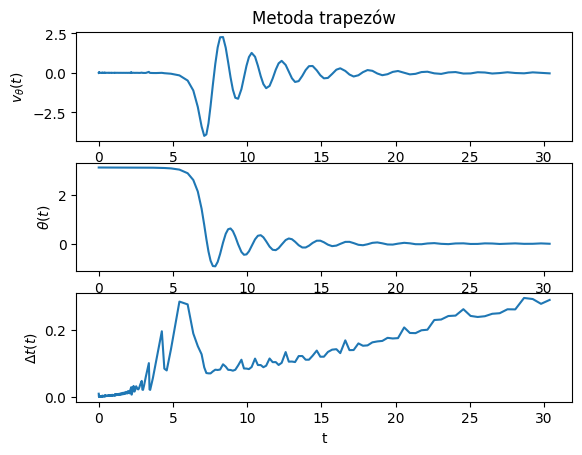

In [52]:
starting_params = [
    {
        "alpha_0": 0.5,
        "alpha_1": 1000.0,
        "lambda": 1.0,
        "g": 9.81,
        "R": 1.0,
        "m": 1.0,
        "tol": 1e-2,
        "theta_0": np.deg2rad(179),
        "v_0": 0,
        "start_dt": 0.01,
        "S": 0.75,
        "p": 2,
        "t_max": 30.0,

        "method": RK2,
        "method_name": "Metoda trapezów",
    }
]

for params in starting_params:
    solve(params)